In [15]:
import xarray as xr
import numpy as np
import argparse
import os
import fdasrsf.curve_functions as curve_functions
import tqdm
import umap
#import umap.plot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import classify_style
import sklearn.model_selection as model_selection
import classify_style

In [38]:
class args:
    min_area = 500
    min_periphery_factor = 6

fragment_fraglets = classify_style.read_fraglets("../netcdf/fragments", args())
codebook_fraglets = classify_style.read_fraglets("../netcdf/style", args())
classify_style.normalize_fraglets(fragment_fraglets)
classify_style.normalize_fraglets(codebook_fraglets)

Reading fraglets images from ../netcdf/fragments/fraglets.nc
Read 7194 fraglets.
Remaining fraglets after filtering: 1839.
Reading fraglets images from ../netcdf/style/fraglets.nc
Read 5559 fraglets.


Normalizing fraglets:   1%|          | 22/1839 [00:00<00:08, 218.69it/s]

Remaining fraglets after filtering: 1055.


Normalizing fraglets: 100%|██████████| 1055/1055 [00:04<00:00, 221.93it/s]


In [39]:
full_label = codebook_fraglets['style'].astype('str').str.cat(
    codebook_fraglets['allograph'].astype('str')
).values
full_label_encoder = LabelEncoder()
codebook_fraglets['full_label'] = ('fraglet_id', full_label_encoder.fit_transform(full_label))

style_label = codebook_fraglets['style'].astype('str').values
style_label_encoder = LabelEncoder()
codebook_fraglets['style_label'] = ('fraglet_id', style_label_encoder.fit_transform(style_label))


In [40]:
codebook_fraglets

<xarray.Dataset>
Dimensions:       (contour_idx: 100, fraglet_id: 1055, pos: 2)
Coordinates:
  * fraglet_id    (fraglet_id) object 'style_Archaic_Alef_3_0' ... 'style_Her...
  * contour_idx   (contour_idx) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * pos           (pos) object 'r' 'c'
Data variables:
    contour       (fraglet_id, contour_idx, pos) float64 43.0 -0.5 ... 48.0 16.5
    style         (fraglet_id) object Archaic Archaic ... Herodian Herodian
    allograph     (fraglet_id) object Alef Alef Alef Alef ... Taw Taw Taw Taw
    img_id        (fraglet_id) object style_Archaic_Alef_3 ... style_Herodian...
    area          (fraglet_id) float64 576.0 618.0 575.0 ... 577.0 506.0 676.0
    center        (fraglet_id, pos) float64 31.53 16.88 29.16 ... 36.53 26.51
    periphery     (fraglet_id) float64 145.1 152.5 145.0 ... 176.0 147.3 192.2
    contour_norm  (fraglet_id, contour_idx, pos) float64 0.1098 ... -0.06215
    full_label    (fraglet_id) int64 0 0 0 0 1 1 1 1 ... 60 60 60 60 60 60 60 60
    style_label   (fraglet_id) int64 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2

In [41]:
img_train, img_test = model_selection.train_test_split(codebook_fraglets.img_id, train_size=0.75, stratify=codebook_fraglets.style)

In [52]:
train_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_train), drop=True)
test_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_test), drop=True)

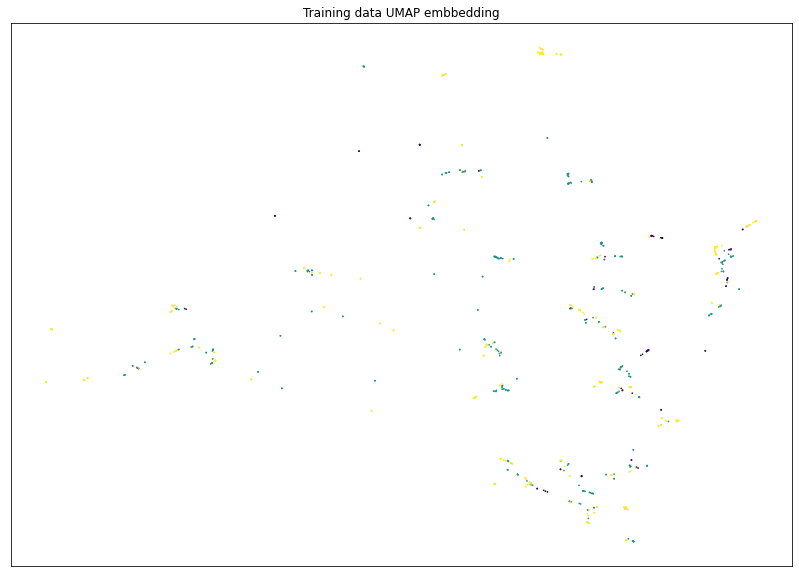

In [49]:
train_features = train_ds['contour_norm'].values.reshape(-1,200)
feature_projection = umap.UMAP()
train_embedding = feature_projection.fit_transform(train_features, y=train_data.full_label)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding.T, s=0.5, c=train_data.style_label, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Training data UMAP embbedding');
plt.show()

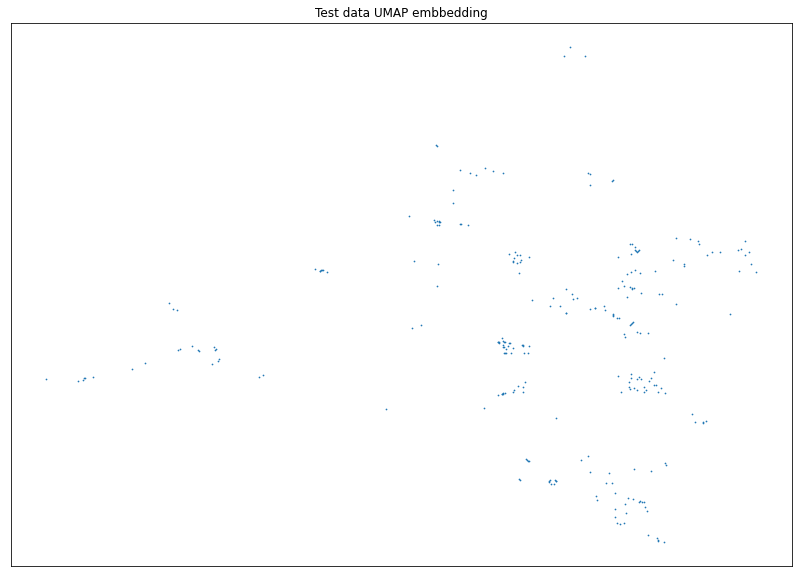

In [53]:
test_features = test_ds['contour_norm'].values.reshape(-1,200)
test_embedding = feature_projection.transform(test_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*test_embedding.T, s=0.5, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Test data UMAP embbedding');
plt.show()

In [57]:
from sklearn.neighbors import KNeighborsClassifier
fraglet_style = KNeighborsClassifier(n_neighbors=3)
fraglet_style.fit(train_embedding, train_ds.style_label)

style_pred = fraglet_style.predict(test_embedding)

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_ds.style_label, style_pred)

array([[10, 11,  9],
       [ 5, 67, 47],
       [ 9, 32, 80]])